# Trabajo Práctico 2: Análisis de series temporales de EEG



<p style="text-align: justify;">
En el marco de la materia optativa *Ciencia de Datos* estudiamos series temporales adquiridas mediante la técnica de neuroimágenes de electroencefalogragía (EEG). En la [página web de la materia](http://www.dc.uba.ar/materias/cienciadatos) se encuentran disponibles los [datos](http://calamaro.exp.dc.uba.ar/~fraimondo/cienciadatos/data/) utilizados, así como también las [referencias teóricas](http://www.dc.uba.ar/materias/cienciadatos/teoricas) y la [guía](https://gist.github.com/fraimondo/57990372c3c8a87c2c1bd290bffaa46f) para el desarrollo de los análisis correspondientes. **agregar resumen de lo que hicimos en el trabajo**
</p> 

## 1. Datos

<p style="text-align: justify;">
La técnica de electroencefalografía (EEG) consiste en medir la actividad eléctrica del cerebro. Para su medición, se utilizan electrodos (sensores) que se ubican en el cuero cabelludo. Cada electrodo mide en forma independiente las fluctuaciones de voltaje, generando una señal analógica que es amplificada y luego digitalizada. Los sistemas de EEG suelen variar en cantidad y ubicación de los electrodos, y en la frecuencia de muestreo. Los datos utilizados en este trabajo provienen de un sistema de EEG con 256 electrodos de solucion salina digitalizados a 250 Hz. Los mismos, corresponden a una evaluación cognitiva realizada a 20 sujetos, de los cuales el 50% posee capacidades cognitivas normales (Grupo S), mientras que los resultados para el 50% restante determinaron que poseen capacidades cognitivas severamente disminuidas (Grupo P). Cada evaluación dura aproximadamente 30 minutos, en los cuales son estimulados auditivamente aproximadamente unas 1200 veces.
</p> 

### 1.1. Preprocesado <a id='preprocesado'></a>

<p style="text-align: justify;">
Uno de los principales problemas del EEG es su naturaleza ruidosa. Los voltajes que se miden en el cuero cabelludo son una mezcla de actividad eléctrica del cerebro, actividad muscular (EMG) y ruido del ambiente. Se denomina artefactos a toda fluctuacion de voltaje registrado que no proviene de actividad neuronal. La tarea de "limpiar" los datos comunmente se denomina preprocesamiento. Existen varios metodos y mecanismos para aislar la actividad neuronal, aunque no hay una única solución óptima. Los detalles de procesamiento de desarrollan a continuación:
<ol>
  <li> Los datos son filtrados en 4 pasos consecutivos:</li>
  <ul>
    <li> Highpass en 0.5 Hz (butterworth de orden 6).</li>
    <li> Lowpass en 45 Hz (butterworth de orden 8).</li>
    <li> Notch en 50 Hz.</li>
    <li> Notch en 100 Hz.</li>
  </ul>  
  <li> La grabación continua de 30 minutos es cortada tomando como parámetro el inicio de la estimulación auditiva (T0). Cada segmento (denominado epoch o trial) tiene una duración de 1.54 segundos y comienza 200 ms antes de T0. En otras palabras, cada epoch comienza en -0.200s y termina en 1.34s donde 0s es la ocurrencia de un estímulo auditivo. </li>
  <li> Para poder comparar los epochs, se realiza lo que se denomina Baseline Correction. En los 200ms previos al estímulo auditivo, todos los epochs están en un periodo de reposo (no hay estimulación). La técnica de baseline correction consiste en centrar en cero la media durante ese periodo para cada electrodo. </li>
  <li> Epochs y electrodos con artefactos son descartados por un metodo automatizado basado en peak-to-peak amplitude y detección de electrodos con alta varianza. </li>
  <li> Los datos son re-referenciados utilizando average reference. </li>
  <li> La información de los electrodos que fueron descartados en el punto 4 es obtenida interpolando los vecinos para que todos los EEG contengan la misma cantidad de electrodos (256). </li>
</ol>
</p> 

### 1.2. Cargando los datos

<p style="text-align: justify;">
Se cargaron los paquetes de Python utilizados en el procesado de los datos
</p> 

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy as sp
import os
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
import scipy.signal as scs
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatProgress
from IPython.display import display
import time

In [3]:
import glob

<p style="text-align: justify;">
Cargamos los datos dispuestos en la subcarpeta *dataset/*
</p> 

In [4]:
p01 = sio.loadmat('dataset/S01.mat')

In [5]:
type(p01)

dict

In [6]:
p01_mat = p01['data']

In [31]:
# plot(p01_mat[0,0,:])

<p style="text-align: justify;">
Cargamos los parámetros de adquisición
</p> 

In [8]:
DURACION = 30 * 60  # s
DUR_EPOCH = 1.54  # s
FREQ_SAMPLE = 250  # hz
N_ELECTRODOS = 256 
N_ESTIMULO = 1200
dur_sample = 1 / float(FREQ_SAMPLE)  # s
cant_samples_epoch = DUR_EPOCH / dur_sample
print('Cant samples x epoch: {}'.format(int(cant_samples_epoch)))

Cant samples x epoch: 385


In [33]:
p01_mat.shape

(657, 256, 201)

Interpretamos como: epochs x electrodo x samples

    Consultar

<p style="text-align: justify;">
Si bien en el paso 4 del [preprocesado](#preprocesado) de los datos se borraron los electrodos con alta varianza, para que todos los EEG tengan el mismo numero de electrodos en el paso 6 se rellenan los electrodos faltantes a partir de interpolar los electrodos vecinos. Por eso el numero de electrodos sigue siendo 256 y entonces la 2da dimension son los electrodos.
</p> 

## 2. Análisis de frecuencias

### 2.a: Media en electrodos 8, 44, 80, 131, 185 y fft con frecuencias en eje Y y trials en eje X

<p style="text-align: justify;">
</p> 

In [34]:
# recorte = p01_mat[:, [8,44,80,131,185], :]
## el 1er electrodo es el 0 por como indexa Python, entonces el electrodo 8 se indexa como 7 por ejemplo,
## y entonces se pueden obtener los indices de los electrodos que se quiere usar a partir de restarle 1 al numero de electrodo
array_electrodos = [7,43,79,130,184]
recorte = p01_mat[:, array_electrodos, :] 
recorte.shape

(657, 5, 201)

In [35]:
promedio = np.mean(recorte, axis=1)
promedio.shape

(657, 201)

<function __main__.f>

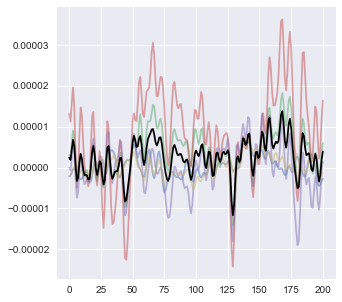

In [36]:
def f(epoch):
    plt.figure(figsize=(5, 5))
    for i in range(len(array_electrodos)):
        plot(recorte[epoch, i, :], alpha=0.5)
    plot(promedio[epoch, :], color='black') 
interact(f, epoch=(0, 20))

In [37]:
## f, Pxx = scs.welch(promedio)
fs=FREQ_SAMPLE
#nperseg=256
#window = scs.get_window('hanning', 4 * fs)
#f, Pxx = scs.welch(promedio, fs=fs, window=window, nperseg=4*fs, noverlap = 2*fs)
f, Pxx = scs.welch(promedio, fs=fs)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


In [38]:
len(f), len(Pxx)

(101, 657)

In [39]:
#plt.semilogy(f, Pxx)
#plt.ylim([0.5e-3, 1])
#plt.xlabel('frequency [Hz]')
#plt.ylabel('PSD [V**2/Hz]')
#plt.show()

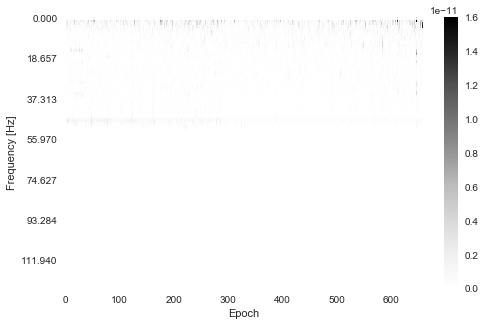

In [40]:
plt.figure(figsize=(8, 5))
imshow(Pxx.T, aspect='auto')
tick_select = range(0, len(f), 15)
tick_labels = ['{:.3f}'.format(x) for x in f[tick_select]]
yticks(tick_select, tick_labels)
xlabel('Epoch')
ylabel('Frequency [Hz]')
colorbar()

No se puede observar mucho en este caso. Probamos promediar todos los sujetos.

Para no tener que abrir todas las matrices, vamos a usar una matriz de _epoch_ x _samples_ como acumulador en la que vamos a sumar los valores de cada matriz. Además vamos a contar para cada _epoch_ cuantos valores se sumaron de forma de saber como promediar.

In [41]:
todas_las_matrices = glob.glob('dataset/*.mat')

In [42]:
electrodos_selec = [8, 44, 80, 131, 185]
contador_suma = np.zeros(0)
matriz_base = np.zeros((0,201))
for nombre_matriz in todas_las_matrices:
    data = sio.loadmat(nombre_matriz)['data']
    recorte = data[:, electrodos_selec, :]
    promedio = np.mean(recorte, axis=1)
    
    assert(promedio.shape[1] == 201)
    
    # Caso donde la nueva matriz tiene más épocas
    if (promedio.shape[0] > contador_suma.shape[0]): 
        tam_ant = contador_suma.shape[0]
        nuevo_contador = np.zeros(promedio.shape[0])  # Creo un nuevo arreglo de contadores del nuevo tamaño
        nuevo_contador[:tam_ant] = contador_suma # Actualizo los valores viejos en la región importante
        contador_suma = nuevo_contador 
        
        nueva_matriz = np.zeros((promedio.shape[0], 201))  # Creo una nueva matriz del nuevo tamaño
        nueva_matriz[0:matriz_base.shape[0], :] = matriz_base  # Actualizo la región importante
        matriz_base = nueva_matriz
        
    matriz_base[0:promedio.shape[0], :] += promedio  # Sumo los valores del sujeto en su región
    contador_suma[0:promedio.shape[0]] += np.ones(promedio.shape[0])  # Sumo uno a cada epoch actualizado

In [43]:
reshape_contador_suma = contador_suma.reshape((contador_suma.shape[0], 1))
promedio_gral = matriz_base / reshape_contador_suma

(1596, 201)


Ellipsis

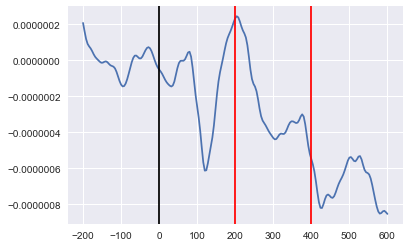

In [44]:
print(promedio_gral.shape)
plot(np.arange(201) * dur_sample * 1000 - 200, promedio_gral.mean(axis=0))
axvline(0, color='black')
axvline(200, color='red')
axvline(400, color='red')
...

In [45]:
f, Pxx = scs.welch(promedio_gral)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


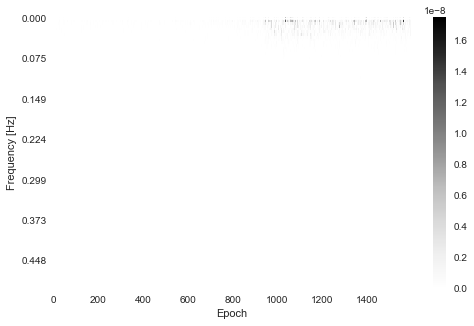

In [46]:
plt.figure(figsize=(8, 5))
imshow(Pxx.T, aspect='auto')
tick_select = range(0, len(f), 15)
tick_labels = ['{:.3f}'.format(x) for x in f[tick_select]]
yticks(tick_select, tick_labels)
xlabel('Epoch')
ylabel('Frequency [Hz]')
colorbar()

In [47]:
for nombre_matriz in sorted(todas_las_matrices):
    data = sio.loadmat(nombre_matriz)['data']
    print(nombre_matriz, data.shape)

dataset\P01.mat (894, 256, 201)
dataset\P02.mat (687, 256, 201)
dataset\P03.mat (700, 256, 201)
dataset\P04.mat (1596, 256, 201)
dataset\P05.mat (857, 256, 201)
dataset\P06.mat (944, 256, 201)
dataset\P07.mat (947, 256, 201)
dataset\P08.mat (901, 256, 201)
dataset\P09.mat (539, 256, 201)
dataset\P10.mat (931, 256, 201)
dataset\S01.mat (657, 256, 201)
dataset\S02.mat (407, 256, 201)
dataset\S03.mat (809, 256, 201)
dataset\S04.mat (746, 256, 201)
dataset\S05.mat (697, 256, 201)
dataset\S06.mat (769, 256, 201)
dataset\S07.mat (789, 256, 201)
dataset\S08.mat (800, 256, 201)
dataset\S09.mat (628, 256, 201)
dataset\S10.mat (767, 256, 201)


### 2.a.2: Calcular la potencia media (entre epochs) para cada frecuencia y graficar la potencia en funcion de la frecuencia para cada canal

<p style="text-align: justify;">
Calculamos el espectro para un sujeto.
</p> 

In [64]:
fs=FREQ_SAMPLE
freq, Pxx_trials = scs.welch(p01_mat[:,:,:], fs=fs)
Pxx_channels = np.mean(Pxx_trials, axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


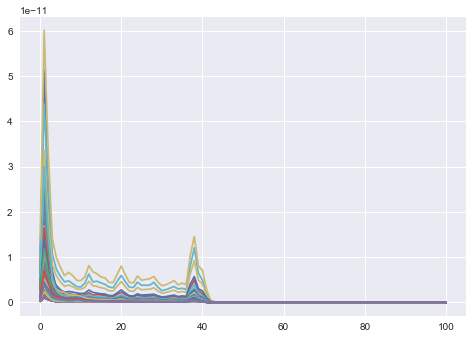

In [66]:
plot(Pxx_channels.T)
show()

<p style="text-align: justify;">
En este caso, la frecuencia de Nyquist es 125 Hz, aunque el filtro aplicado en el pre-procesamiento pone el límite en 45 Hz.
</p> 

### Bandas de frecuencias

<p style="text-align: justify;">
Un EEG es tipicamente descripto en terminos de oscilaciones. Estas oscilaciones son agrupadas en bandas de frecuencia:
<ul>
<li> Delta $<$ 4 Hz </li>
<li> 4 Hz $<=$ Theta $<$ 8 Hz </li>
<li> 8 Hz $<=$ Alpha $<$ 13 Hz </li>
<li> 13 Hz $<=$ Beta $<$ 30 Hz </li>
<li> 30 Hz $<=$ Gamma $<$ NyquistHighpass en 0.5 Hz (butterworth de orden 6) </li>
</ul>  
El cálculo del poder espectral en cada banda se realiza sumando los valores obtenidos de la FFT que corresponden a las frecuencias incluídas en la misma. Adicionalmente, suelen computarse los valores normalizados, que indican la relacion entre el poder espectral de cada banda sobre el poder espectral total.
</p> 

<p style="text-align: justify;">
Calculamos el poder espectral de cada banda de frecuencias para cada canal para un sujeto.
</p> 

In [108]:
Pxx_channels_delta = np.sum(Pxx_channels [:, freq < 4], axis=1)
#Pxx_channels_delta
#idx = (freq > 4)*(freq < 8)
#np.where(idx)
Pxx_channels_theta = np.sum(Pxx_channels [:, (freq >= 4)*(freq < 8)], axis=1)
Pxx_channels_alpha = np.sum(Pxx_channels [:, (freq >= 8)*(freq < 13)], axis=1)
Pxx_channels_beta = np.sum(Pxx_channels [:, (freq >= 13)*(freq < 30)], axis=1)
Pxx_channels_gamma = np.sum(Pxx_channels [:, freq >= 30], axis=1)

<p style="text-align: justify;">
Promediamos entre canales.
</p> 

In [107]:
P_delta = np.mean(Pxx_channels_delta)
P_theta = np.mean(Pxx_channels_theta)
P_alpha = np.mean(Pxx_channels_alpha)
P_beta = np.mean(Pxx_channels_beta)
P_gamma = np.mean(Pxx_channels_gamma)

<p style="text-align: justify;">
Ahora lo calculamos para todos los sujetos.
</p> 

In [109]:
dataDir = "dataset/"
filelist = os.listdir( dataDir )

# progress bar
pbar = FloatProgress(min=0, max=len(filelist)) # instantiate the bar
display(pbar) # display the bar

fs=FREQ_SAMPLE

count = 0
#P_delta_subjects = np.zeros(len(filelist))
#P_theta_subjects = np.zeros(len(filelist))
P_alpha_subjects = np.zeros(len(filelist))
#P_beta_subjects = np.zeros(len(filelist))
#P_gamma_subjects = np.zeros(len(filelist))
for f in range(len(filelist)):
    file = filelist[f]
    #print(file)
    data = sio.loadmat( dataDir+file )
    data_array = data['data']
    freq_subjects, Pxx_trials_subjects = scs.welch(data_array[:,:,:], fs=fs)
    Pxx_channels_subjects = np.mean(Pxx_trials_subjects, axis=0)
    #Pxx_channels_delta_subjects = np.sum(Pxx_channels_subjects [:, freq < 4], axis=1)
    #Pxx_channels_theta_subjects = np.sum(Pxx_channels_subjects [:, (freq >= 4)*(freq < 8)], axis=1)
    Pxx_channels_alpha_subjects = np.sum(Pxx_channels_subjects [:, (freq >= 8)*(freq < 13)], axis=1)
    #Pxx_channels_beta_subjects = np.sum(Pxx_channels_subjects [:, (freq >= 13)*(freq < 30)], axis=1)
    #Pxx_channels_gamma_subjects = np.sum(Pxx_channels_subjects [:, freq >= 30], axis=1)
    # promedio
    #P_delta_subjects[f] = np.mean(Pxx_channels_delta_subjects)
    #P_theta_subjects[f] = np.mean(Pxx_channels_theta_subjects)
    P_alpha_subjects[f] = np.mean(Pxx_channels_alpha_subjects)
    #P_beta_subjects[f] = np.mean(Pxx_channels_beta_subjects)
    #P_gamma_subjects[f] = np.mean(Pxx_channels_gamma_subjects)
    # para la progress bar
    pbar.value += 1 # signal to increment the progress bar
    time.sleep(.1)
    count += 1

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


<p style="text-align: justify;">
Ploteamos los valores de potencia espectral de la banda alpha obtenidos para todos los sujetos.
</p> 

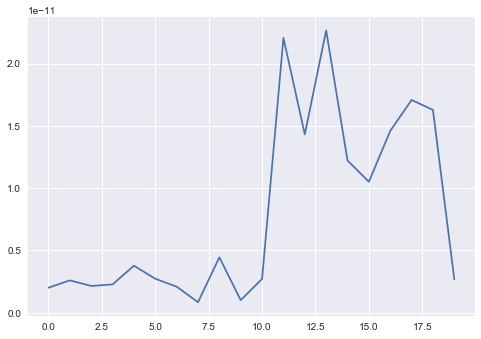

In [111]:
plot(P_alpha_subjects)
plt.show()

<p style="text-align: justify;">
Ploteamos las distribuciones de potencia espectral de la banda alpha separando los sujetos en grupos de controles y pacientes.
</p> 

### Gráficos categóricos de seaborn (8 tipos)

<p style="text-align: justify;">
1) stripplot
</p> 

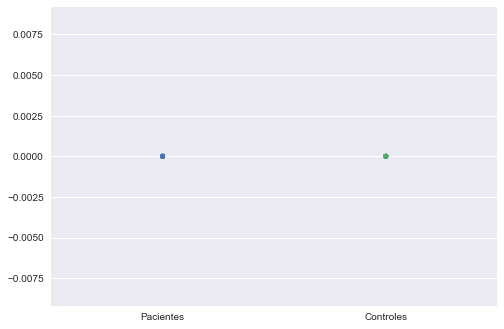

In [114]:
etiquetas = np.repeat(['Pacientes','Controles'], 10)
ax = sns.stripplot(x=etiquetas, y=P_alpha_subjects)

<p style="text-align: justify;">
2) swarmplot
</p> 

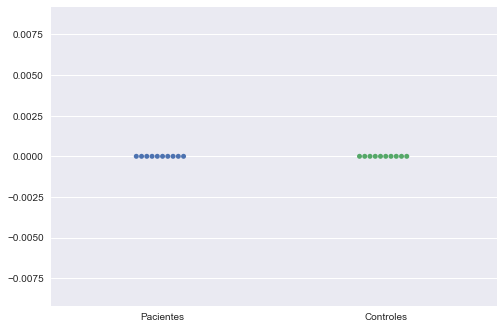

In [115]:
etiquetas = np.repeat(['Pacientes','Controles'], 10)
ax = sns.swarmplot(x=etiquetas, y=P_alpha_subjects)

<p style="text-align: justify;">
3) boxplot
</p> 

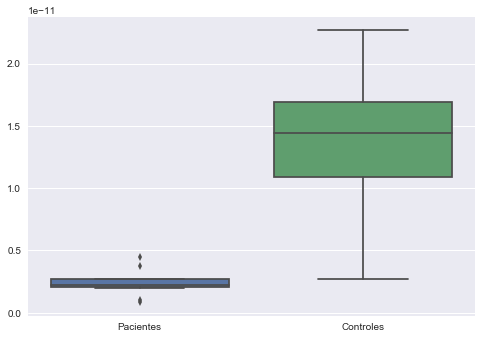

In [116]:
etiquetas = np.repeat(['Pacientes','Controles'], 10)
ax = sns.boxplot(x=etiquetas, y=P_alpha_subjects)

<p style="text-align: justify;">
4) violinplot
</p> 

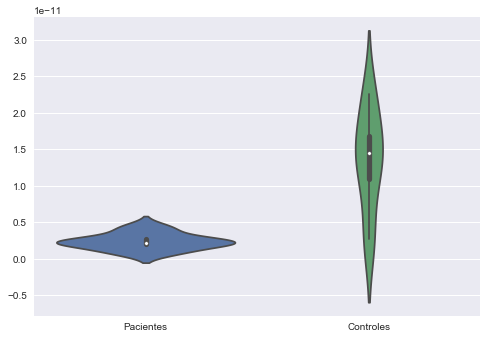

In [112]:
etiquetas = np.repeat(['Pacientes','Controles'], 10)
ax = sns.violinplot(x=etiquetas, y=P_alpha_subjects)

<p style="text-align: justify;">
5) lvplot
</p> 

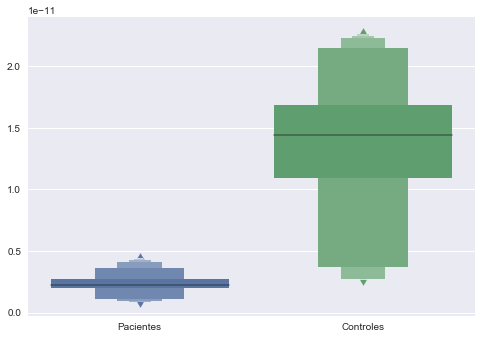

In [117]:
etiquetas = np.repeat(['Pacientes','Controles'], 10)
ax = sns.lvplot(x=etiquetas, y=P_alpha_subjects)

<p style="text-align: justify;">
6) pointplot
</p> 

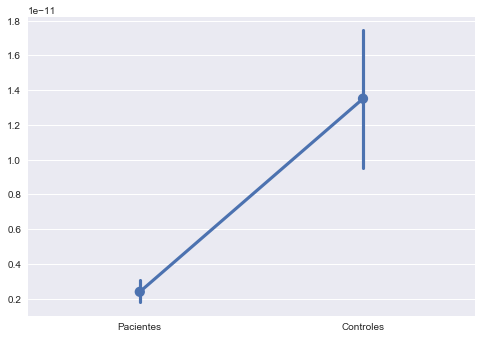

In [118]:
etiquetas = np.repeat(['Pacientes','Controles'], 10)
ax = sns.pointplot(x=etiquetas, y=P_alpha_subjects)

<p style="text-align: justify;">
7) barplot
</p> 

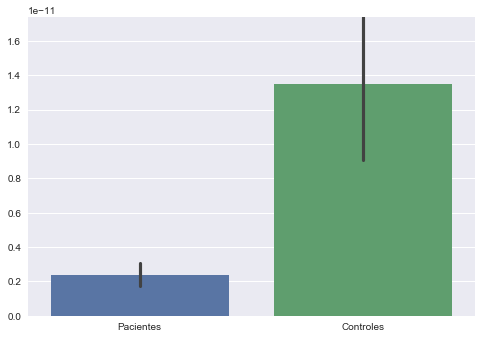

In [119]:
etiquetas = np.repeat(['Pacientes','Controles'], 10)
ax = sns.barplot(x=etiquetas, y=P_alpha_subjects)

<p style="text-align: justify;">
8) countplot
</p> 

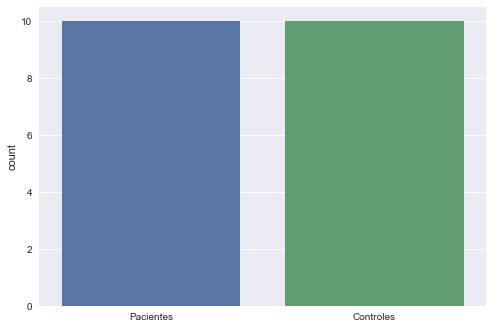

In [124]:
etiquetas = np.repeat(['Pacientes','Controles'], 10)
ax = sns.countplot(x=etiquetas, data=pd.DataFrame(data=P_alpha_subjects)) # no admitía numpy array por lo que pasamos a pandas data frame

<p style="text-align: justify;">
Para cada banda de frecuencia, graficar según lo elegido previamente y realizar un test estadístico apropiado. Repetir los análisis para los valores normalizados.
</p> 

## 3. Análisis de información

<p style="text-align: justify;">
Los métodos basados en teoría de la información como entropía, entropia mutua, entropía condicional e información mutua forman un conjunto de técnicas estadísticas/matemáticas de gran utilidad en ciencia, ingeniería y comunicaciones. Las métricas basadas en la teoría de la información crean un marco para la cuantificación de información y conectividad entre señales. En el caso de EEG, puede ser para evaluar la cantidad de información en cada electrodo, la información mutua o conectividad entre pares de electrodos, etc.
</p> 

### 3.1. Análisis de información intra-electrodo

<p style="text-align: justify;">
Calculamos distintas medidas de información intra-electrodos para cada serie temporal. 
</p> 

<p style="text-align: justify;">
La entropía es una medida de la cantidad de información que posee una serie de símbolos. La formula esta data por: 
</p> 
\begin{equation*}
H (X) = - \sum_{i=1}^n p(x_{i}) log[p(x_{i})]
\end{equation*}
donde n es el número de símbolos y p(x) es la probabilidad de observar x.

<p style="text-align: justify;">
Utilizamos la regla de *Scott* para definir el valor óptimo del número de bins N a partir de las propiedades de las series.
</p> 

In [10]:
##N = max(p01_mat[0, 0, :]) - min(p01_mat[0, 0, :])/(2*(np.subtract(*np.percentile(p01_mat[0, 0, :], [75, 25])))*pow(len(p01_mat[0, 0, :]),-1/3)) # regla de Freedman-Diaconis
N = max(p01_mat[0, 0, :]) - min(p01_mat[0, 0, :])/(3.5*np.std(p01_mat[0, 0, :])*pow(len(p01_mat[0, 0, :]),-1/3)) # regla de Scott
N

3.1620185495811928

In [49]:
# plot(p01_mat[0, 0, :])

<p style="text-align: justify;">
Ahora calculamos el histograma definiendo como parámetro que use la regla de *Scott* para definir el valor óptimo del número de bins N a partir de las propiedades de las series.
</p> 

In [12]:
hist, bin_edges = np.histogram(p01_mat[0, 0, :],bins='scott')
hist

array([15, 18, 27, 38, 55, 33,  7,  5,  3], dtype=int64)

<p style="text-align: justify;">
Nos da más bins que los que habíamos calculado a mano.
</p> 

    Por que?

In [51]:
sum(hist/len(p01_mat[0, 0, :]))

1.0

<p style="text-align: justify;">
Calculamos la entropía para esa serie en particular.
</p> 

In [52]:
sp.stats.entropy(hist/len(p01_mat[0,0,:]),qk=None)

1.9171567175211381

<p style="text-align: justify;">
Calculamos la matriz de entropías de todas las series para un sujeto.
</p> 

In [53]:
H = np.zeros((p01_mat.shape[0], p01_mat.shape[1]))
for i in range(p01_mat.shape[0]):
    for j in range(p01_mat.shape[1]):
        hist, bin_edges = np.histogram(p01_mat[i, j, :], bins='scott')
        H [i, j] = sp.stats.entropy(hist/len(p01_mat[i, j, :]), qk=None)

<p style="text-align: justify;">
Corroboramos que el elemneto de matriz correspondiente al cálculo anterior de el mismo valor.
</p> 

In [54]:
H[0,0]

1.9171567175211381

<p style="text-align: justify;">
Calculamos la entropía media entre canales y trials para ese sujeto.
</p> 

In [55]:
Hmean = np.mean(H)
Hmean

1.9340914539635157

<p style="text-align: justify;">
Entonces ya tenemos cómo calcular la entropía media para cada sujeto. Corremos un loop entre todos los sujetos guardando los resultados de entropía media por sujeto.
</p> 

In [56]:
dataDir = "dataset/"
filelist = os.listdir( dataDir )

# progress bar
pbar = FloatProgress(min=0, max=len(filelist)) # instantiate the bar
display(pbar) # display the bar

count = 0
Hmean = np.zeros(len(filelist))
for f in range(len(filelist)):
    file = filelist[f]
    #print(file)
    data = sio.loadmat( dataDir+file )
    data_array = data['data']
    H = np.zeros((data_array.shape[0], data_array.shape[1]))
    for i in range(data_array.shape[0]):
        #print("{0:.0f}".format(i/data_array.shape[0]*100),end="% \t")
        for j in range(data_array.shape[1]):
            hist, bin_edges = np.histogram(data_array[i, j, :], bins='scott')
            H [i, j] = sp.stats.entropy(hist/len(data_array[i, j, :]), qk=None)
    #print ("\n")
    Hmean[f] = np.mean(H)
    pbar.value += 1 # signal to increment the progress bar
    time.sleep(.1)
    count += 1

<p style="text-align: justify;">
Ploteamos las distribuciones de entropías media separando los sujetos en grupos de controles y pacientes.
</p> 

In [57]:
#plot(Hmean)
#filelist
etiquetas = np.repeat(['Pacientes','Controles'], 10)

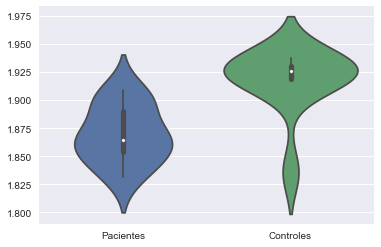

In [58]:
ax = sns.violinplot(x=etiquetas, y=Hmean)

<p style="text-align: justify;">
Aplicamos algún test no paramétrico.
</p> 

### 3.2. Análisis de información inter-electrodo

<p style="text-align: justify;">
La información mutua, como su nombre lo define, es la cantidad de información que dos variables comparten. Una forma de expresar la información mutua es en función de la entropía y la entropía conjunta:
</p> 
\begin{equation*}
I(X; Y) = H (X) - H (X|Y) = H (X) + H (Y) - H (X,Y) = \sum_{x} \sum_{y} p(x, y) log\frac{p(x, y)}{p(x) p(y)}
\end{equation*}

<p style="text-align: justify;">
Cálculo
</p> 

<p style="text-align: justify;">
Otra forma de calcular la informacion mutua es usando los histogramas bivariados entre las señales.
</p> 

In [ ]:
#def calc_MI(x, y, bins):
#    c_xy = np.histogram2d(x, y, bins)[0]
#    mi = mutual_info_score(None, None, contingency=c_xy)
#    return mi

### 3.3. Transformación simbólica

<p style="text-align: justify;">
Todas las medidas descriptas previamente trabajan sobre seríes simbólicas con alfabetos finitos, como por ejemplo, texto ASCII. Sin embargo, los datos de EEG estan guardados como elementos de punto flotante de doble precision (64 bits). Si calculamos la entropía de un canal de EEG de 300 muestras, probablemente obtengamos que la probabilidad de obtener cada simbolo posible es 0 o 1/300. El alfabeto sigue siendo finito con $2^{64}$ elementos, pero la cantidad de simbolos es muy grande.

Una solución a este problema consiste en transformar la serie temporal de punto flotante a una serie simbólica con un alfabeto finito de cardinalidad acotada.
</p> 

<p style="text-align: justify;">
Para la transformación simbólica de las series, seguimos el procedimiento descrito en *King, Sitt et al 2013*. De esta manera, partimos la serie temporal en sub-vectores de k datos (k=3) y nos fijamos qué formas distintas pueden tener esos sub-vectores de acuerdo al orden de sus valores de intensidad. Para k=3, las formas posibles son 3!=6. En la siguiente figura se pueden observar las formas posibles y su símbolo asignado.
</p> 

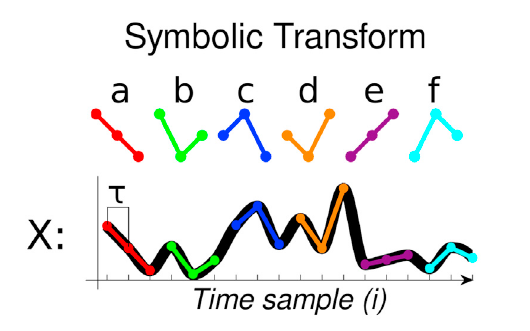

In [16]:
from IPython.display import Image
Image("symb.png")

<p style="text-align: justify;">
De esta manera se observa que si los índices del orden descendente de los valores de intensidad del sub-vector son [0 1 2] entonces se le asigna el símbolo 'a', si son [0 2 1] se le asigna 'b', etc. También se puede observar que los k elementos del sub-vector pueden ser asignado a tiempos consecutivos (Tau = 1 sample) o que se pueden seleccionar de manera salteada. Por ejemplo, se pueden elegir con Tau = 2, 4, 8 samples.
</p> 

    Para Tau's distintos a 1 sample, los subvectores se arman de manera concatenada y sin overlapping? Estaría tirando un montón de datos. Y no le estaría dando más importancia al 1er valor de la serie (por ejemplo) que a otros? Puedo confíar más en ese valor que en otros?

### Entropía de los vectores simbólicos

<p style="text-align: justify;">
Aplicamos la transformación simbólica de una serie de prueba.
</p> 

In [6]:
#np.reshape(p01_mat[0, 0, :],(3, -1)).shape
index = pd.DataFrame(np.argsort(np.reshape(p01_mat[0, 0, :],(3, -1)).T))
index_symbs = pd.DataFrame([[0, 1, 2],[0, 2, 1],[1, 0, 2],[1, 2, 0],[2, 1, 0],[2, 0, 1]], index=['a','b','c','d','e','f'])
symbs = np.zeros(int(len(p01_mat[0, 0, :])/3))
for s in range(index_symbs.shape[0]):
    index_symb = pd.Series(index_symbs.iloc[s])
    #np.where((index == index_symb).all(axis=1))
    symbs[np.where((index[0] == index_symb[0]) & (index[1] == index_symb[1]) & (index[2] == index_symb[2]))[0]] = s
symbs

array([ 1.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  5.,  5.,  5.,  1.,  3.,
        5.,  5.,  1.,  0.,  0.,  1.,  5.,  1.,  1.,  5.,  5.,  5.,  5.,
        5.,  1.,  2.,  2.,  0.,  1.,  5.,  5.,  5.,  5.,  1.,  1.,  1.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  1.,  1.,  1.,  4.,  3.,
        2.,  2.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,
        2.,  3.])

<p style="text-align: justify;">
Hacemos la transformación simbólica de las series y calculamos la entropía media para cada sujeto.
</p> 

** No correr. Tarda una eternidad**

In [9]:
dataDir = "dataset/"
filelist = os.listdir( dataDir )

# progress bar
pbar = FloatProgress(min=0, max=len(filelist)) # instantiate the bar
display(pbar) # display the bar

index_symbs = pd.DataFrame([[0, 1, 2],[0, 2, 1],[1, 0, 2],[1, 2, 0],[2, 1, 0],[2, 0, 1]], index=['a','b','c','d','e','f'])
count = 0
Hmean_symb = np.zeros(len(filelist))
for f in range(len(filelist)):
    file = filelist[f]
    data = sio.loadmat( dataDir+file )
    data_array = data['data']
    H_symb = np.zeros((data_array.shape[0], data_array.shape[1]))
    for i in range(data_array.shape[0]):
        for j in range(data_array.shape[1]):
            index = pd.DataFrame(np.argsort(np.reshape(data_array[i, j, :],(3, -1)).T))
            symbs = np.zeros(int(len(data_array[i, j, :])/3))
            for s in range(index_symbs.shape[0]):
                index_symb = pd.Series(index_symbs.iloc[s])
                symbs[np.where((index[0] == index_symb[0]) & (index[1] == index_symb[1]) & (index[2] == index_symb[2]))[0]] = s
            symbs
            hist, bin_edges = np.histogram(symbs, bins=range(index_symbs.shape[0]+1))
            H_symb [i, j] = sp.stats.entropy(hist/len(symbs), qk=None)
    Hmean_symb[f] = np.mean(H_symb)
    pbar.value += 1 # signal to increment the progress bar
    time.sleep(.1)
    count += 1
    

KeyboardInterrupt: 

In [ ]:
plot(Hmean_symb)
#filelist
#etiquetas = np.repeat(['Pacientes','Controles'], 10)

In [ ]:
ax = sns.violinplot(x=etiquetas, y=Hmean_symb)

### Información mutua de los vectores simbólicos

<p style="text-align: justify;">
Aplicamos la transformación simbólica de una serie de prueba.
</p> 

In [6]:
#np.reshape(p01_mat[0, 0, :],(3, -1)).shape
index = pd.DataFrame(np.argsort(np.reshape(p01_mat[0, 0, :],(3, -1)).T))
index_symbs = pd.DataFrame([[0, 1, 2],[0, 2, 1],[1, 0, 2],[1, 2, 0],[2, 1, 0],[2, 0, 1]], index=['a','b','c','d','e','f'])
symbs = np.zeros(int(len(p01_mat[0, 0, :])/3))
for s in range(index_symbs.shape[0]):
    index_symb = pd.Series(index_symbs.iloc[s])
    #np.where((index == index_symb).all(axis=1))
    symbs[np.where((index[0] == index_symb[0]) & (index[1] == index_symb[1]) & (index[2] == index_symb[2]))[0]] = s
symbs

array([ 1.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  5.,  5.,  5.,  1.,  3.,
        5.,  5.,  1.,  0.,  0.,  1.,  5.,  1.,  1.,  5.,  5.,  5.,  5.,
        5.,  1.,  2.,  2.,  0.,  1.,  5.,  5.,  5.,  5.,  1.,  1.,  1.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  1.,  1.,  1.,  4.,  3.,
        2.,  2.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,
        2.,  3.])

<p style="text-align: justify;">
Calculamos la información mutua del vector simbólico calculado previamente consigo mismo, como prueba de la herramienta.
</p> 

In [14]:
MI = normalized_mutual_info_score(symbs, symbs)
MI

1.0

In [15]:
MI = (1/6) * mutual_info_score(symbs, symbs) # SMI segun paper King, Sitt et al 2013
MI

0.022370494017060746

<p style="text-align: justify;">
Para el cálculo de la wSMI (información mutua simbólica pesada) tendríamos que aplicar una máscara que tenga 1s sólo en las diagonales y contradiagonales, de acuerdo a lo hecho en *King, Sitt et al 2013*.
</p> 